In [3]:
import pandas as pd
from scipy.spatial.distance import pdist,cdist, squareform

df = pd.read_csv("datasets/creditcard.csv")

In [21]:
import numpy as np

# Split features and labels
X = np.array(df.drop(columns=["Class"]))
y = df["Class"]

normal_ixs = np.where(y==0)[0]
fraud_ixs = np.where(y==1)[0]

normal_ixs_downsample = np.random.choice(normal_ixs, 5000, replace=False).tolist()
fraud_ixs_downsample = np.random.choice(fraud_ixs, 50, replace=False).tolist()
downsample = normal_ixs_downsample + fraud_ixs_downsample

X = X[downsample]
y = y[downsample]

In [22]:
X.shape, y.shape

((5050, 30), (5050,))

In [23]:
#cdist(X[normal_ixs], X[fraud_ixs])

In [24]:
#np.savetxt('credit_card_downsample', downsample, fmt='%d', delimiter=' ')

finished pca


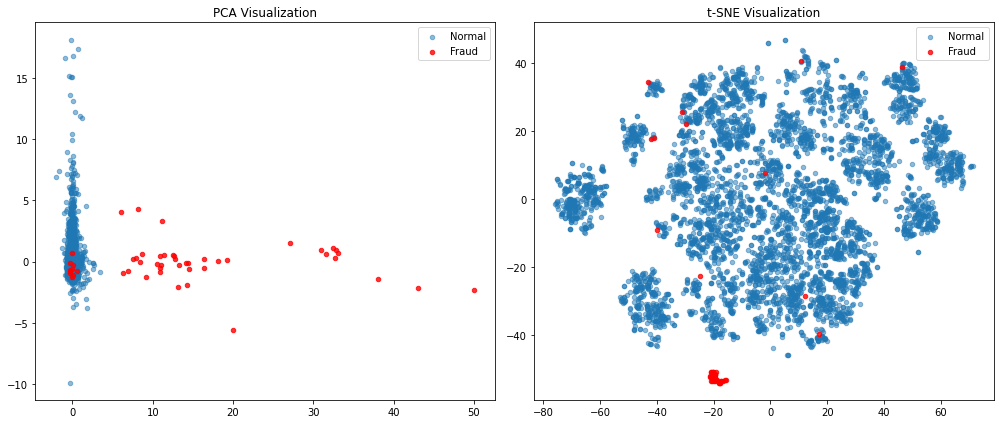

In [25]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS


# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print('finished pca')

#mds =  MDS(n_components=2)
#X_mds = mds.fit_transform(X_scaled)

# t-SNE to 2D
tsne = TSNE(n_components=2, random_state=42, init='pca',perplexity=60, n_iter=1000, learning_rate="auto")
X_tsne = tsne.fit_transform(X_scaled)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA scatter
axes[0].scatter(X_pca[y==0, 0], X_pca[y==0, 1], s=20, alpha=0.5, label="Normal")
axes[0].scatter(X_pca[y==1, 0], X_pca[y==1, 1], s=20, alpha=0.8, label="Fraud", c="red")
axes[0].set_title("PCA Visualization")
axes[0].legend()

# t-SNE scatter
axes[1].scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], s=20, alpha=0.5, label="Normal")
axes[1].scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], s=20, alpha=0.8, label="Fraud", c="red")
axes[1].set_title("t-SNE Visualization")
axes[1].legend()

# PCA scatter
#axes[1].scatter(X_mds[y==0, 0], X_mds[y==0, 1], s=20, alpha=0.5, label="Normal")
#axes[1].scatter(X_mds[y==1, 0], X_mds[y==1, 1], s=20, alpha=0.8, label="Fraud", c="red")
#axes[1].set_title("MDS Visualization")
#axes[1].legend()



plt.tight_layout()
plt.show()

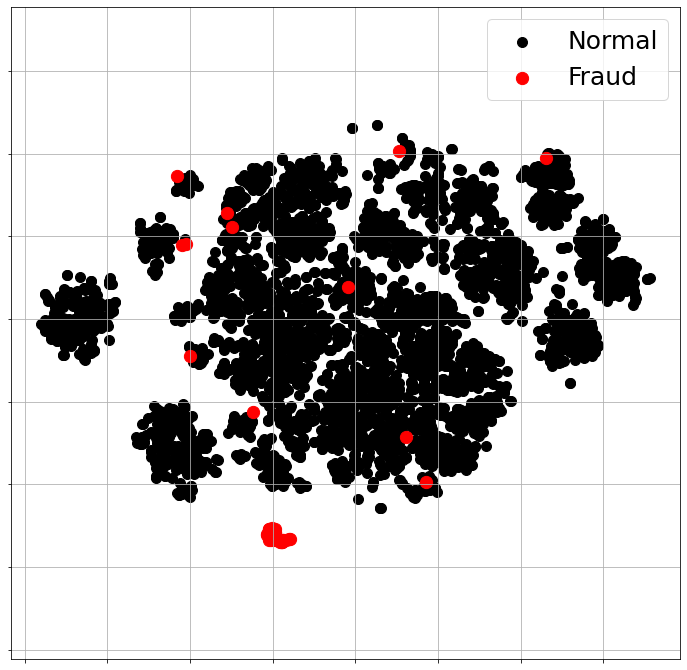

In [26]:
fig, ax = plt.subplots(figsize=(12,12))

ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], s=100,  c='black', label="Normal")
ax.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], s=150, label="Fraud", c="red")
#ax.set_title("t-SNE Visualization")
ax.legend(prop={'size': 25})

plt.savefig('visuals/credit_card/tsne1010_.png')

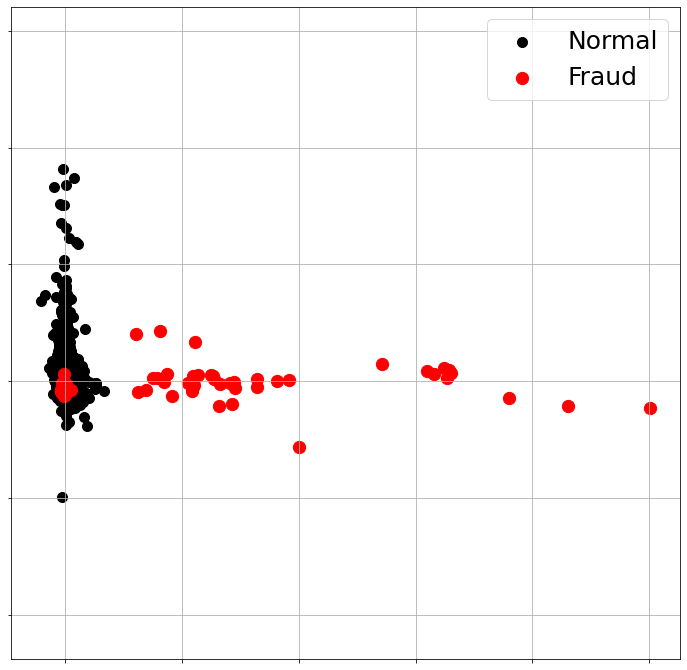

In [27]:
fig, ax = plt.subplots(figsize=(12,12))

ax.grid('on')
ax.axis('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.scatter(X_pca[y==0, 0], X_pca[y==0, 1], s=100,   c='black', label="Normal")
ax.scatter(X_pca[y==1, 0], X_pca[y==1, 1], s=150, label="Fraud", c="red")
#ax.set_title("t-SNE Visualization")
ax.legend(prop={'size': 25})

plt.savefig('visuals/credit_card/pca1010_.png')

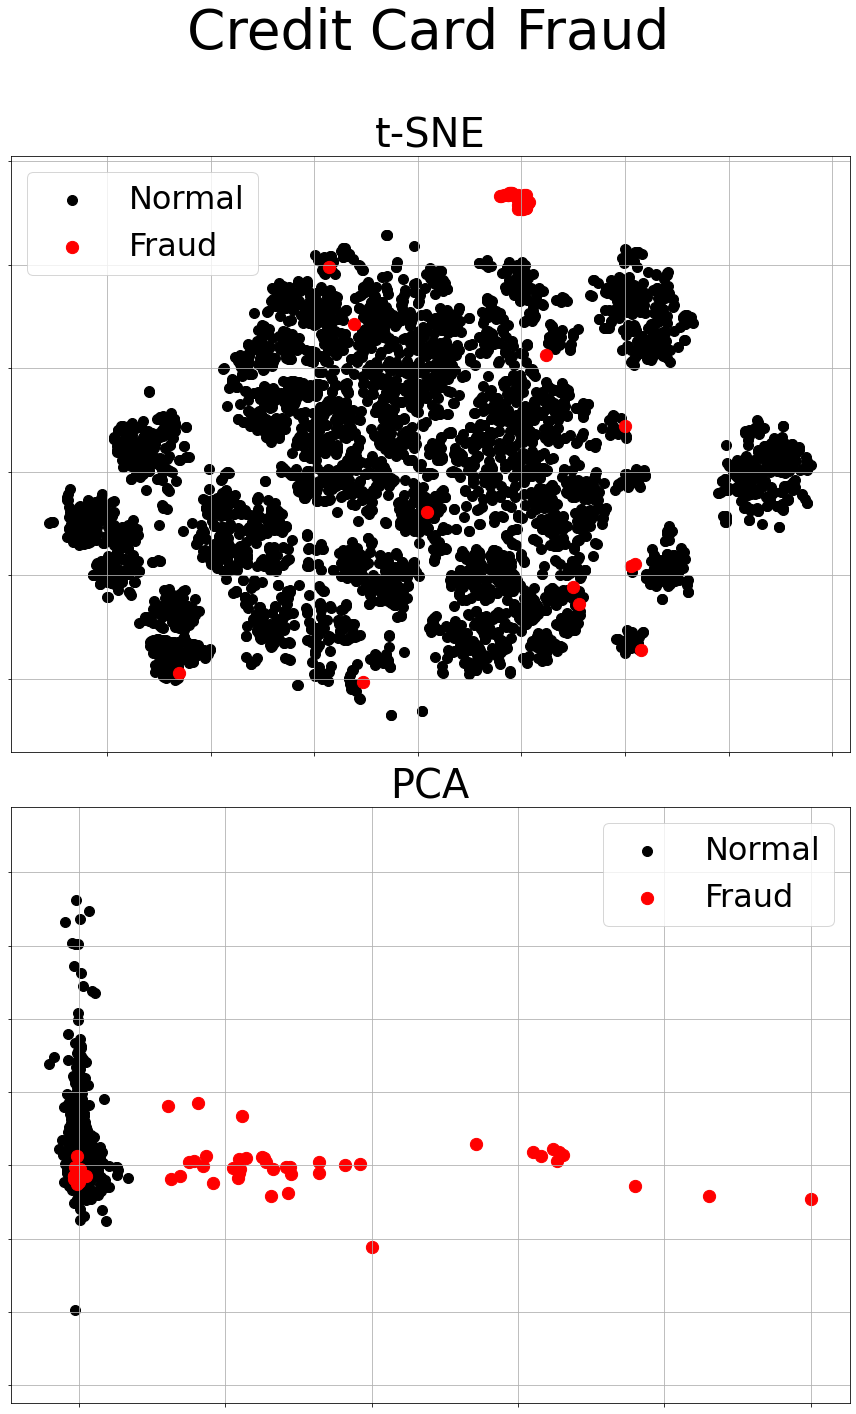

In [41]:
fig, axs = plt.subplots(2,1, figsize=(12,20))

for i in range(2):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].scatter(-X_tsne[y==0, 0], -X_tsne[y==0, 1], s=100,  c='black', label="Normal")
axs[0].scatter(-X_tsne[y==1, 0], -X_tsne[y==1, 1], s=150, label="Fraud", c="red")
axs[0].set_title("t-SNE", fontsize=40)
axs[0].legend(prop={'size': 32})
#axs[0].set_title('t-SNE')

#axs[1].set_title('PCA')
axs[1].scatter(X_pca[y==0, 0], X_pca[y==0, 1], s=100,   c='black', label="Normal")
axs[1].scatter(X_pca[y==1, 0], X_pca[y==1, 1], s=150, label="Fraud", c="red")
axs[1].set_title("PCA", fontsize=40)
axs[1].legend(prop={'size': 32})

plt.suptitle('Credit Card Fraud\n', fontsize=55)

plt.tight_layout()
plt.savefig('visuals/credit_card/combined_fig.png')

In [43]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# caclulates the diameter of a set of points
def diam(pts):
    return max(pdist(pts, metric='euclidean'))

# calculates the alpha-statistic of a point with respect to the other points
def alpha_(pts, pt):
    X = np.concatenate([pts, [pt]] , axis=0)
    X = StandardScaler().fit_transform(X)


    y = np.ones(len(pts) + 1)
    y[-1] = -1

    clf = LinearSVC(C=1e12,dual=False)
    clf.fit(X,y)
    if np.all(clf.predict(X) == y):
        return 2 * (1.0 / np.linalg.norm(clf.coef_))/diam(pts[np.where(y==1)])
    else:
        return 0

In [41]:
from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon
import numpy as np

from sklearn.preprocessing import StandardScaler


# Split features and labels
X = np.array(df.drop(columns=["Class"]))
y = df["Class"]

normal_ixs = np.where(y==0)[0]
fraud_ixs = np.where(y==1)[0]

X_normal = X[np.random.choice(normal_ixs, 5000, replace=False).tolist()]
X_fraud = X[np.random.choice(fraud_ixs, 50, replace=False).tolist()]



In [46]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

X = np.concatenate([X_normal, X_fraud] , axis=0)
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, init='pca',perplexity=60, n_iter=1000, learning_rate="auto")
X_tsne = tsne.fit_transform(X)


og_alphas = []
tsne_alphas = []
pca_alphas = []

for i in tqdm(range(len(X_fraud))):

    og_alphas.append( alpha_(X[:5000], X[5000+i]) )
    tsne_alphas.append( alpha_(X_tsne[:5000], X_tsne[5000+i]) )
    pca_alphas.append( alpha_(X_pca[:5000], X_pca[5000+i]) )
    #tsne_alphas.append( alpha() )


 48%|████▊     | 24/50 [00:42<00:40,  1.54s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 54%|█████▍    | 27/50 [00:46<00:37,  1.61s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 82%|████████▏ | 41/50 [01:12<00:16,  1.87s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 92%|█████████▏| 46/50 [01:20<00:07,  1.82s/it]/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


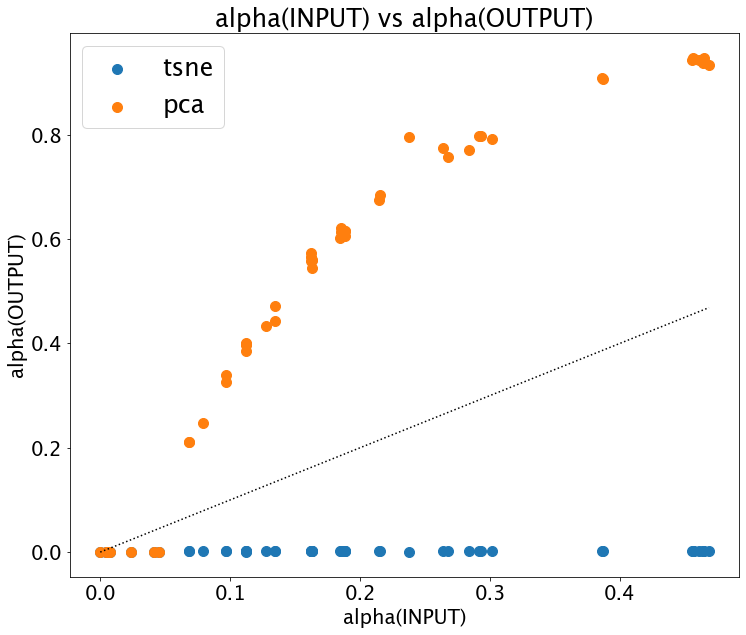

In [80]:
from sklearn.linear_model import LinearRegression


fig, ax = plt.subplots(figsize=(12,10))

x_range = np.linspace(min(og_alphas), max(og_alphas), 100).reshape(-1, 1)


plt.scatter(og_alphas, tsne_alphas, label='tsne', s=100)
#model = LinearRegression().fit(np.array([og_alphas]).T, tsne_alphas)
#y_pred = model.predict(x_range)
#plt.plot(x_range, y_pred, color="blue", linewidth=2)
#print(model.coef_[0])
plt.plot(x_range, x_range, color='black', linestyle=':')


ax.tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
ax.set_xlabel("alpha(INPUT)", fontsize=20)
ax.set_ylabel("alpha(OUTPUT)", fontsize=20)
ax.set_title("alpha(INPUT) vs alpha(OUTPUT)",fontsize=25)
ax.scatter(og_alphas, pca_alphas, label='pca', s=100)
ax.legend(fontsize=25)
#model = LinearRegression().fit(np.array([og_alphas]).T, pca_alphas)
#y_pred = model.predict(x_range)
#plt.plot(x_range, y_pred, color="orange", linewidth=2)
#print(model.coef_[0])



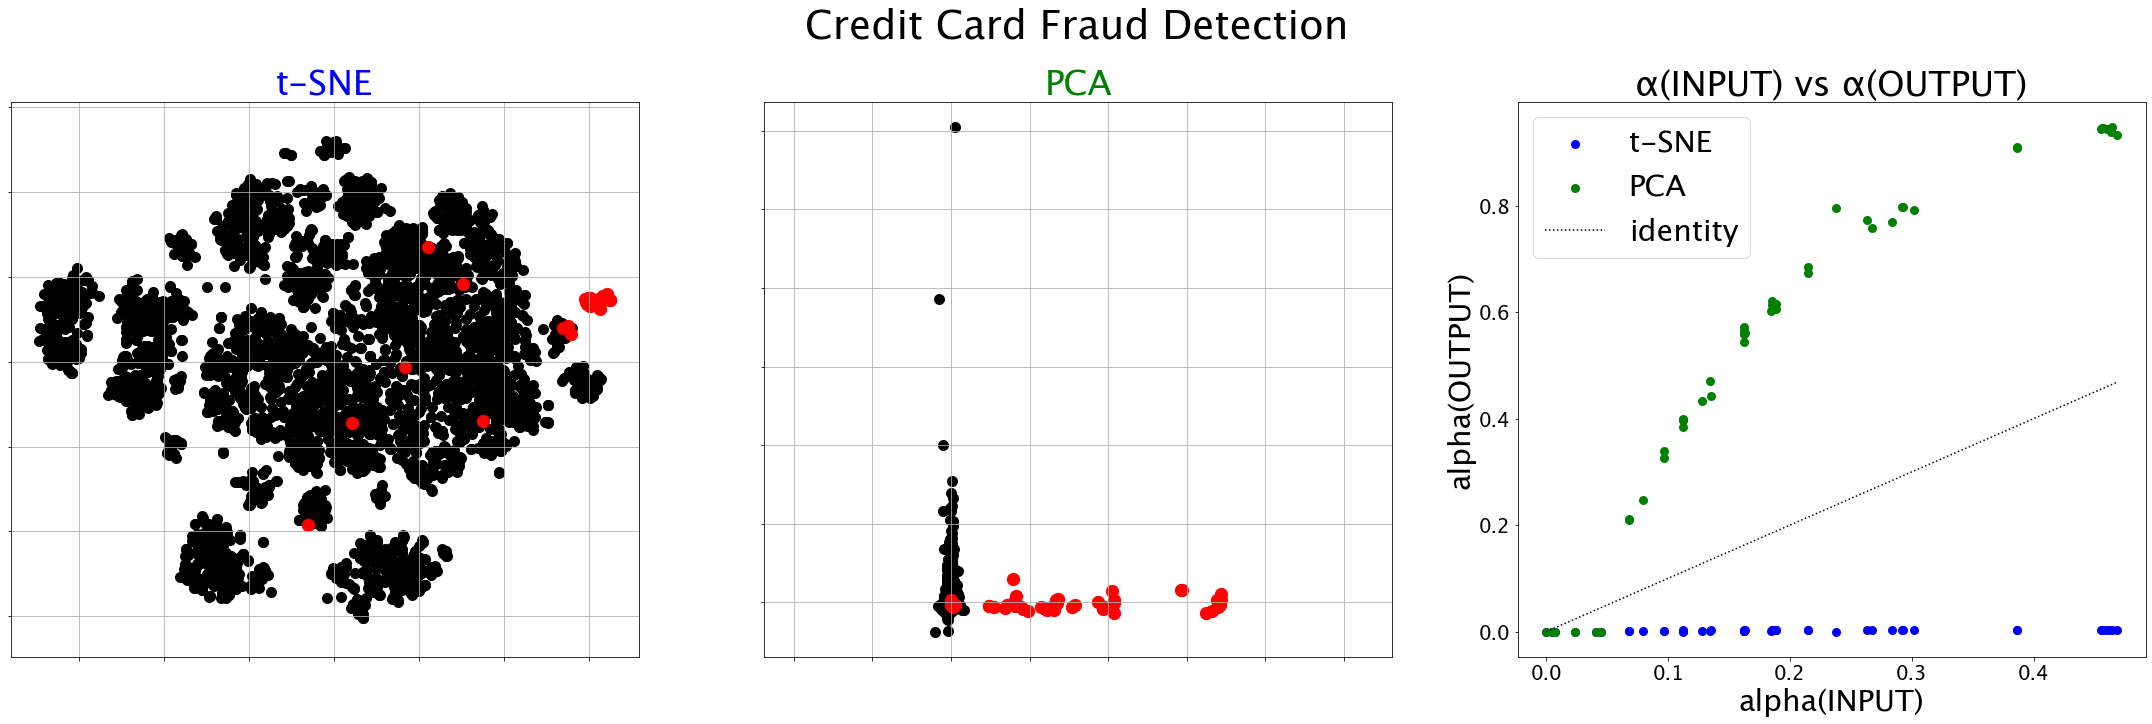

In [108]:
fig, axs = plt.subplots(1,3, figsize=(30,10))
import matplotlib.gridspec as gridspec

#gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 0.3, 1])  
#ax1 = fig.add_subplot(gs[0])

#x_range = np.linspace(min(og_alphas), max(og_alphas), 100).reshape(-1, 1)

id = [min(og_alphas), max(og_alphas)]

for i in range(2):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].set_title('t-SNE', fontsize=35, color='blue')
axs[0].scatter(X_tsne[:5000, 0], X_tsne[:5000, 1], s=100,  c='black', label="Normal")
axs[0].scatter(X_tsne[5000:, 0], X_tsne[5000:, 1], s=150, label="Fraud", c="red")

axs[1].set_title('PCA', fontsize=35, color='green')
axs[1].scatter(X_pca[:5000, 0], X_pca[:5000, 1], s=100,  c='black', label="Normal")
axs[1].scatter(X_pca[5000:, 0], X_pca[5000:, 1], s=150, label="Fraud", c="red")

axs[2].scatter(og_alphas, tsne_alphas, color='blue',linewidth = 3,  label='t-SNE')
axs[2].scatter(og_alphas, pca_alphas, color='green', linewidth = 3, label='PCA')
axs[2].plot([min(og_alphas), max(og_alphas)], [min(og_alphas), max(og_alphas)],  linestyle=':', color='black', label='identity')
axs[2].tick_params(axis='both', which='major', labelsize=20)  # make ticks bigger
axs[2].set_xlabel("alpha(INPUT)", fontsize=30)
axs[2].set_ylabel("alpha(OUTPUT)", fontsize=30)
axs[2].set_title("α(INPUT) vs α(OUTPUT)",fontsize=35)
axs[2].legend(prop={'size': 30})

# get position of the 3rd subplot
pos = axs[2].get_position()
# shift it to the right (x0, y0, width, height)
axs[2].set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

plt.suptitle('Credit Card Fraud Detection', y=1.001, fontsize=40)
plt.tight_layout()
plt.savefig('visuals/credit_card/credit_card_full.png',  bbox_inches='tight')